#### 1. Setup & Data Loading

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid", palette="colorblind")


#### 2. Load 7 seasons of play-by-play data (2016-2022)

In [3]:
pbp_py_run = pd.read_pickle("../datasets/filtered_nfl_run_plays.pkl")

#### 3. Exploratory Analysis

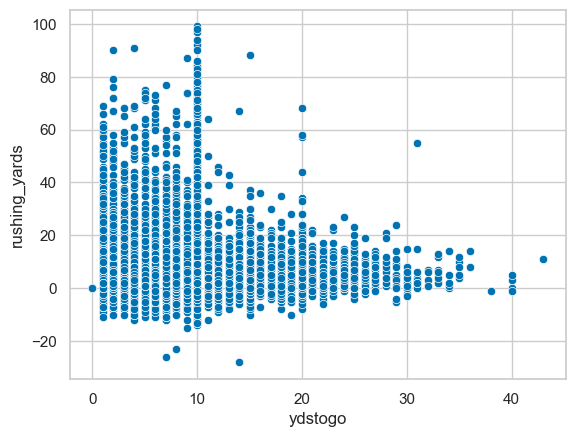

In [4]:
sns.set_theme(style="whitegrid", palette="colorblind") 
sns.scatterplot(data=pbp_py_run, x="ydstogo", y="rushing_yards");
plt.show();

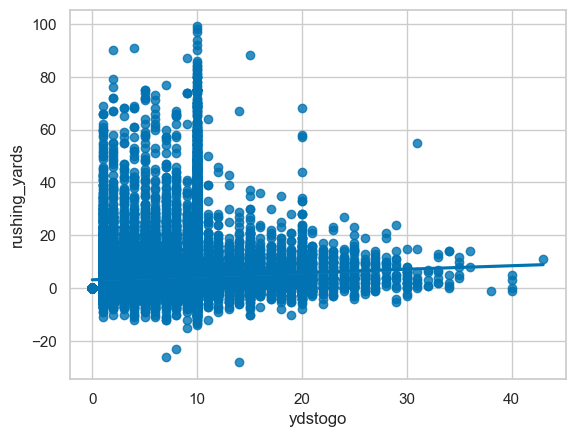

In [5]:
sns.regplot(data=pbp_py_run, x="ydstogo", y="rushing_yards");
plt.show();

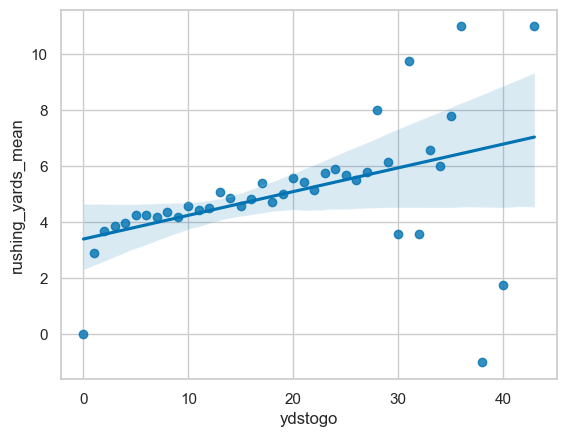

In [7]:
pbp_py_run_ave = pbp_py_run.groupby(["ydstogo"]).agg({"rushing_yards": ["mean"]})
pbp_py_run_ave.columns = list(map("_".join, pbp_py_run_ave.columns))
pbp_py_run_ave.reset_index(inplace=True)
sns.regplot(data=pbp_py_run_ave, x="ydstogo", y="rushing_yards_mean")
plt.show()

#### 4. Linear Regression Model

In [5]:
# Build and fit regression model
model = smf.ols(
    formula='rushing_yards ~ 1 + ydstogo', 
    data=pbp_py_run
)
results = model.fit()

# Create RYOE (Residual Yards Over Expected)
pbp_py_run["ryoe"] = results.resid

# Show model summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     623.7
Date:                Tue, 01 Apr 2025   Prob (F-statistic):          3.28e-137
Time:                        00:37:00   Log-Likelihood:            -3.0102e+05
No. Observations:               92410   AIC:                         6.021e+05
Df Residuals:                   92408   BIC:                         6.021e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2182      0.047     68.125      0.0

Model Explanation:

Uses Ordinary Least Squares (OLS) regression to predict rushing_yards based on ydstogo.

Intercept (~3.22 yards): The expected rush yardage when ydstogo = 0.

ydstogo coefficient (~0.13 yards per yard to go): More yards needed slightly increases expected rushing yards.

R² = 0.7%: The model has low explanatory power, meaning other factors (blocking, defense, play call) drive rushing performance.

Creates "Residual Yards Over Expected" (RYOE): Measures how much a rusher gains beyond model expectations.

#### 5. Rusher Performance Analysis

In [6]:
# Calculate rusher statistics
rusher_stats = (
    pbp_py_run
    .groupby(["season", "rusher_id", "rusher"])
    .agg(
        carries=('ryoe', 'count'),
        total_ryoe=('ryoe', 'sum'),
        ryoe_per_carry=('ryoe', 'mean'),
        ypc=('rushing_yards', 'mean')
    )
    .reset_index()
    .query("carries > 50")  # Minimum qualification
)

# Top 10 by Total RYOE
print(rusher_stats.sort_values("total_ryoe", ascending=False).head(10))

      season   rusher_id     rusher  carries  total_ryoe  ryoe_per_carry  \
1988    2021  00-0036223   J.Taylor      332  417.637078        1.257943   
1439    2020  00-0032764    D.Henry      397  362.926338        0.914172   
1257    2019  00-0034796  L.Jackson      135  353.707586        2.620056   
1143    2019  00-0032764    D.Henry      387  324.075218        0.837404   
1473    2020  00-0033293    A.Jones      222  288.447884        1.299315   
1102    2019  00-0031687  R.Mostert      190  281.790033        1.483105   
318     2016  00-0033045  E.Elliott      344  278.703996        0.810186   
1899    2021  00-0034791    N.Chubb      228  275.946445        1.210291   
2234    2022  00-0034796  L.Jackson       73  275.870922        3.779054   
1558    2020  00-0034791    N.Chubb      221  253.859380        1.148685   

           ypc  
1988  5.454819  
1439  5.206549  
1257  6.800000  
1143  5.131783  
1473  5.540541  
1102  5.831579  
318   5.104651  
1899  5.521930  
2234  7.82